In [75]:
import h5py
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from scipy.signal import find_peaks

sns.set(style="white")
from IPython.core.display import display, HTML
from IPython.display import IFrame
display(HTML('<style>.container { width:100% !important; }</style>'))
matplotlib.rcParams['figure.figsize'] = [24, 8]
matplotlib.rcParams["font.family"] = "HelveticaNeue"
sns.set(font_scale=1.5)
%matplotlib inline

In [2]:
f = h5py.File('../output/max_img.hdf5', 'r')

In [3]:
data = f['max_img']

In [4]:
print(data.shape)
print(data.dtype)

(7106,)
[('start_timestamp', '<f8'), ('frame', '<i8'), ('actual_timestamp', '<f8'), ('area', '<f8'), ('probability', '<f8'), ('img', '<i8', (650, 650, 3))]


In [6]:
timestamp_array = []
for entry in data:
    timestamp_array.append((entry['actual_timestamp'], entry['img']))
timestamp_array.sort(key = lambda x: x[0])

In [10]:
print(datetime.fromtimestamp(timestamp_array[0][0]))
print(datetime.fromtimestamp(timestamp_array[-1][0]))

2019-11-06 12:19:35
2019-11-22 16:17:20


In [42]:
spl_data_path = '../spl/sonycnode-b827eb491436.sonyc_fast.csv'

In [43]:
df = pd.read_csv(spl_data_path, header=2)

In [44]:
df['time'] = pd.to_datetime(df['timestamp'].values.astype(np.int64), unit='s')
df.set_index(pd.DatetimeIndex(df['time']), inplace=True)
df.drop(['time', 'timestamp'], axis=1, inplace=True)

In [45]:
start_date = '2019-11-14T06:00:00'
end_date = '2019-11-15T06:00:00'
mask = (df.index > start_date) & (df.index <= end_date)
df = df[(df.index < start_date) | (df.index > end_date)]

In [149]:
def calc_leq(data):
    return 10 * np.log10(np.mean(10 ** (data / 10)))


def calcl95(data):
    stat_percentile = 100 - 95
    return np.nanpercentile(data, stat_percentile)

def calcl90(data):
    stat_percentile = 100 - 90
    return np.nanpercentile(data, stat_percentile)

def calcl10(data):
    stat_percentile = 100 - 10
    return np.nanpercentile(data, stat_percentile)

def calcl5(data):
    stat_percentile = 100 - 5
    return np.nanpercentile(data, stat_percentile)

In [135]:
window_seconds = 60 * 5

if 'fast' in spl_data_path:
    window_seconds = window_seconds * 8

In [150]:
l95_vals = df['dBAS'].rolling(center=True, window=window_seconds).apply(calcl95, raw=True).values
df['l95'] = l95_vals

In [151]:
l90_vals = df['dBAS'].rolling(center=True, window=window_seconds).apply(calcl90, raw=True).values
df['l90'] = l90_vals

In [152]:
l10_vals = df['dBAS'].rolling(center=True, window=window_seconds).apply(calcl10, raw=True).values
df['l10'] = l10_vals

In [153]:
l5_vals = df['dBAS'].rolling(center=True, window=window_seconds).apply(calcl5, raw=True).values
df['l5'] = l5_vals

In [ ]:
print('')
print('Start: \t %s' % df.index[0])
print('End: \t %s' % df.index[-1])
print('')
print('Total avg SPL: \t %0.2f dBA' % calc_leq(df['dBAS']))
print('Total max SPL: \t %0.2f dBA' % df['dBAS'].max())
print('Total min SPL: \t %0.2f dBA' % df['dBAS'].min())


Start: 	 2019-11-05 05:00:17
End: 	 2019-11-23 05:00:33

Total avg SPL: 	 67.19 dBA
Total max SPL: 	 112.04 dBA
Total min SPL: 	 41.50 dBA


In [ ]:
resamp_str = '3600s'
df_resamp = df.resample(resamp_str).apply(calc_leq)

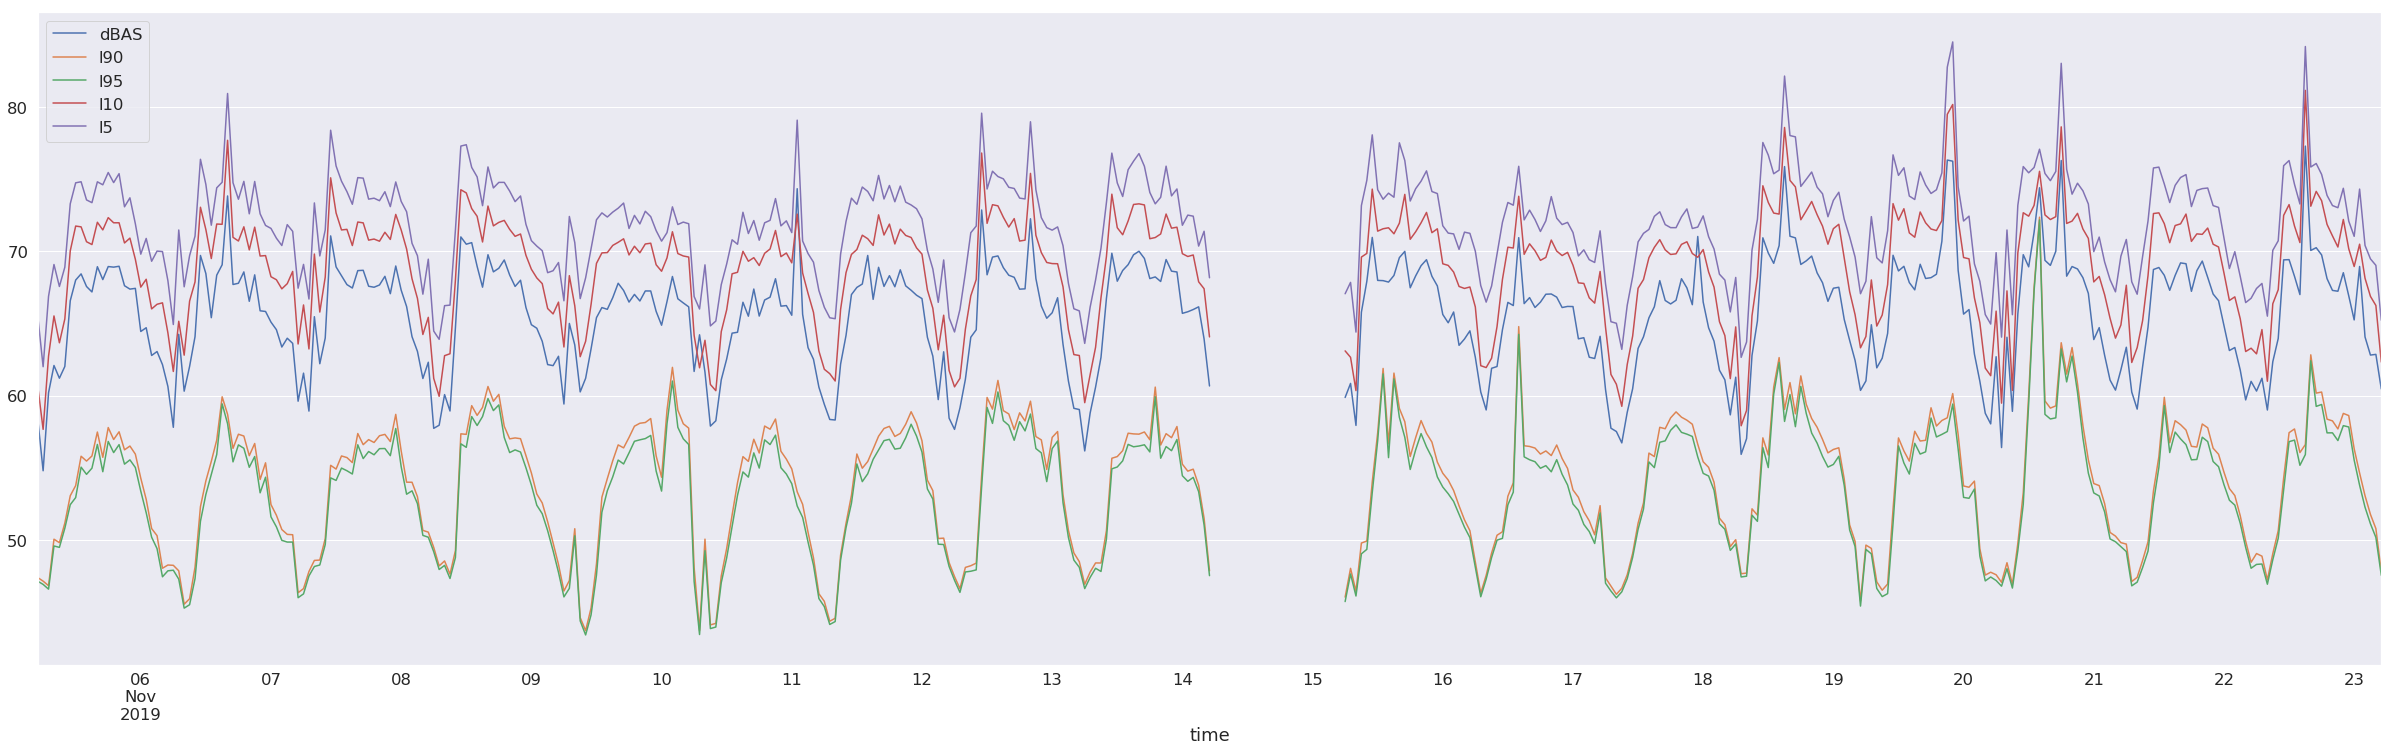

In [ ]:
df_resamp.plot(y=['dBAS', 'l90', 'l95', 'l10', 'l5'], figsize=(42,12))

In [ ]:
cnt = 0
plot_window_seconds = 60
distance = 10
pass_width = 5

if 'fast' in spl_data_path:
    plot_window_seconds = plot_window_seconds * 8
    distance = distance * 8
    pass_width = pass_width * 8
    
for entry in timestamp_array:
    cnt += 1
    dt = pd.to_datetime(datetime.fromtimestamp(entry[0]))
    i = np.argmin((np.abs(df.index - dt)))
    pass_range = df.iloc[i-plot_window_seconds : i+plot_window_seconds]
    
    peaks, properties = find_peaks(pass_range['dBAS'], prominence=1, width=pass_width, distance=distance)
    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax = pass_range.plot(y=['dBAS', 'l90', 'l10', 'l5'], figsize=(24,8), ax=ax1)
    ax1.axvline(dt, color='r', linestyle='--')

#     peak_zipped = zip(peaks, properties["left_ips"], properties["right_ips"])
    peak_zipped = zip(peaks, properties["left_ips"], properties["right_ips"])
    
    for (peak, prop_lips, prop_rips) in sorted(peak_zipped, key=lambda x: pass_range['dBAS'].iloc[x[0]], reverse=True):
        print(pass_range['dBAS'].iloc[peak])
        ax1.axvline(pass_range.index[int(prop_lips)], color='k', linestyle='--')
        ax1.axvline(pass_range.index[int(prop_rips)], color='k', linestyle='--')
#         ax1.axvline(pass_range.index[peak], color='k', linestyle='--')
#         ax1.axhline(y=pass_range['dBAS'].iloc[peak], xmin=pass_range.index[int(prop_lips)], xmax=pass_range.index[int(prop_rips)], color='k', linestyle='--')
#         break
    ax1.set_ylim([40, 95])
    ax1.set(title=dt)
    ax2.imshow(entry[1], interpolation='nearest')
    if cnt == 10:
        break

78.03
76.68
86.14
76.68
86.14
77.09
72.69
86.14
77.09
72.69
70.16
77.09
72.69
70.16
79.88
77.09
70.16
79.88
82.88
76.41
82.88
77.17
76.41
